In [1]:
import matplotlib.pyplot as plt
from carla import Automata
import numpy as np
import random
import pyads 

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# import torch
# from torch import nn # nn contains all of pytorch's building blocks to a neural network
# model = nn.Sequential(nn.Linear(3,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU(),nn.Linear(32,1))
# model.load_state_dict(torch.load("../model_3-64-32-1"))

def response(controller,setpoints,startPoint):
    y =[]
    tension_1=startPoint[0]
    tension_2=startPoint[1]
    for sp in setpoints:
        controllerOutput= controller.step(tension_1,sp)
        noise = (random.random()-0.5) *0.005 +1
        tension_0 = (1.9108896*tension_1 -0.9110488*tension_2 + 0.00287053 * controllerOutput)  * noise
        y.append(tension_0)

        # input = torch.tensor([tension_1,tension_2,controllerOutput],dtype=torch.float32)
        # tension_0 = model(input).to('cpu').detach().numpy()[0]
        # y.append(tension_0)

        tension_2=tension_1
        tension_1=tension_0
    return y

# connect to plc and open connection
plc = pyads.Connection('127.0.0.1.1.1', pyads.PORT_TC3PLC1)
plc.open()
class PID:
    def __init__(self,Kp,Tn,Tv) -> None:
        global plc
        
        plc.write_by_name("MAIN.fKp", Kp)
        plc.write_by_name("MAIN.tTn", Tn)
        plc.write_by_name("MAIN.tTv", Tv)
        plc.write_by_name("MAIN.reset", True)


    def step(self,measurement,setpoint):
        global plc

        plc.write_by_name("MAIN.measuredForce", measurement)
        plc.write_by_name("MAIN.lrSetPointTension", setpoint)
        plc.write_by_name("MAIN.step", True)
        while plc.read_by_name("MAIN.step"):
            pass

        return plc.read_by_name("MAIN.lrPIDOut")

In [2]:

kAutomata=Automata(0.0001,1.5,0.02,0.3)
tnAutomata=Automata(20,80,0.02,0.3) # 20ms - 80ms
tvAutomata=Automata(0,60,0.02,0.3) # 0ms - 50ms
# mass = 10
# spring_constant=30
# damping_constant=10
# G = ctrl.tf([damping_constant, spring_constant], [mass, damping_constant, spring_constant])
u = np.ones(1000)*50
startPoint=[5.7332,5.7332]

[5.258615, 5.142467, 4.918094, 4.819486, 4.7044616, 4.637757, 4.575148, 4.533447, 4.4981556, 4.4729543, 4.452677, 4.4376845, 4.42592, 4.417067, 4.410205, 4.4049973, 4.400986, 4.39793, 4.39558, 4.3937864, 4.392411, 4.39136, 4.390553, 4.389936, 4.389465, 4.389103, 4.3888264, 4.388615, 4.3884516, 4.3883286, 4.3882303, 4.3881593, 4.388104, 4.3880625, 4.3880286, 4.388004, 4.3879843, 4.38797, 4.387959, 4.3879495, 4.3879423, 4.387937, 4.3879337, 4.387931, 4.3879285, 4.3879275, 4.387926, 4.3879247, 4.3879247, 4.3879237, 4.3879232, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4.387921, 4

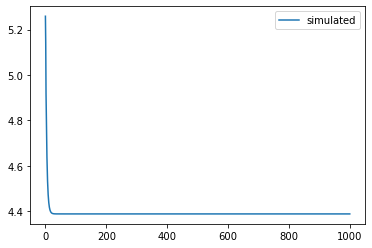

In [4]:
# controller = PID(100,
#                 int(75),
#                 int(10))
# y_simulated = response(controller,u,startPoint)
# print(y_simulated)
# print(np.sum(np.abs(u - y_simulated))) 
# plt.plot(y_simulated,label="simulated")
# plt.legend()
# plt.show()

explore
0 5059.704572879584
10 6496.645191992413
20 3939.3413786597475
30 9293.592290882152
40 9199.561749158613
50 4911.131106657249
60 4359.503569768621
70 7001.919026453837
80 11820.440290699586
90 4661.253581546766
100 5339.843978220528
110 15158.029243600578
120 5524.453816243997
130 3427.5769140503344
140 6150.018987120329
150 5995.280289328068
160 3884.8270403523366
170 11501.635165380841
180 6018.759839743235
190 18719.076281924958
200 5345.209067363184
210 6934.915836921817
220 4300.747942433605
230 4855.6204993564625
240 5710.258539041669
250 4734.43205075792
260 4164.596972869334
270 4883.423782371255
280 27524.679264814604
290 6533.135853858452


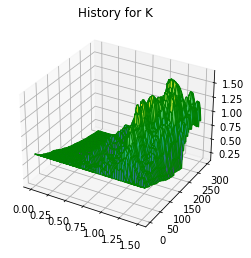

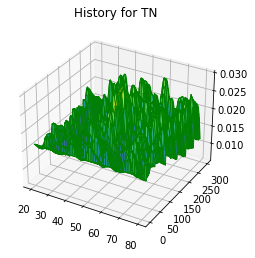

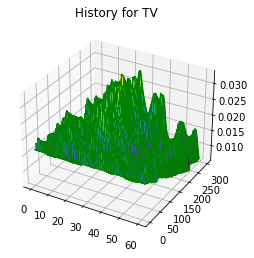

In [3]:

# explore
print("explore")
for i in range(300):
    k = kAutomata.explore()
    tn = int(tnAutomata.explore())
    tv = int(tvAutomata.explore())

    controller = PID(k,tn,tv)

    y_simulated = response(controller,u,startPoint)
    J = np.sum(np.abs(u - y_simulated))
    
    kAutomata.update(J)
    tnAutomata.update(J)
    tvAutomata.update(J)
    if(i%10!=0): continue
    print(i, J)

array = np.array(kAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(kAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for K')
plt.show()

array = np.array(tnAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tnAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TN')
plt.show()

array = np.array(tvAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tvAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TV')
plt.show()

explore
0 5059.704572879584
10 6496.645191992413
20 3939.3413786597475
30 9293.592290882152
40 9199.561749158613
50 4911.131106657249
60 4359.503569768621
70 7001.919026453837
80 11820.440290699586
90 4661.253581546766
100 5339.843978220528
110 15158.029243600578
120 5524.453816243997
130 3427.5769140503344
140 6150.018987120329
150 5995.280289328068
160 3884.8270403523366
170 11501.635165380841
180 6018.759839743235
190 18719.076281924958
200 5345.209067363184
210 6934.915836921817
220 4300.747942433605
230 4855.6204993564625
240 5710.258539041669
250 4734.43205075792
260 4164.596972869334
270 4883.423782371255
280 27524.679264814604
290 6533.135853858452


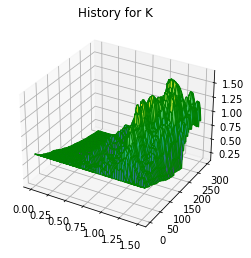

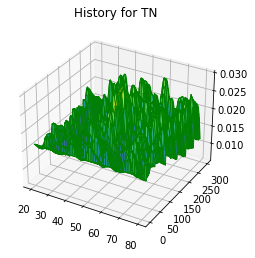

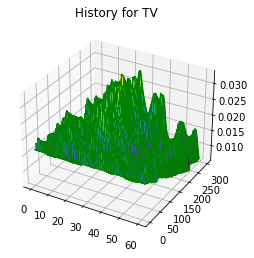

In [ ]:

# explore
print("explore")
for i in range(300):
    k = kAutomata.explore()
    tn = int(tnAutomata.explore())
    tv = int(tvAutomata.explore())

    controller = PID(k,tn,tv)

    y_simulated = response(controller,u,startPoint)
    J = np.sum(np.abs(u - y_simulated))
    
    kAutomata.update(J)
    tnAutomata.update(J)
    tvAutomata.update(J)
    if(i%10!=0): continue
    print(i, J)

array = np.array(kAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(kAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for K')
plt.show()

array = np.array(tnAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tnAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TN')
plt.show()

array = np.array(tvAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tvAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TV')
plt.show()

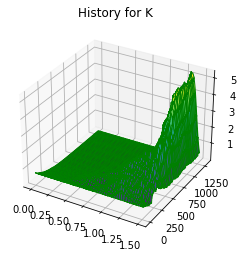

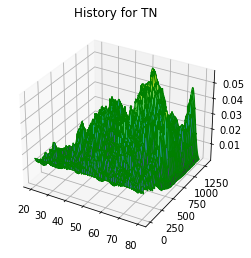

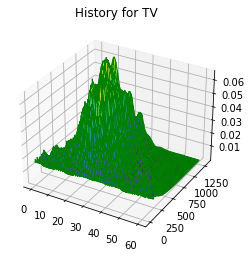

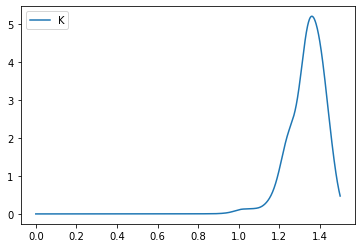

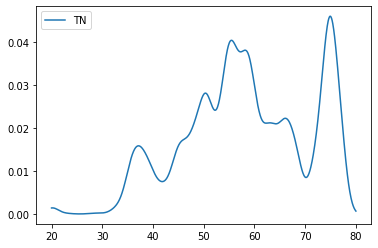

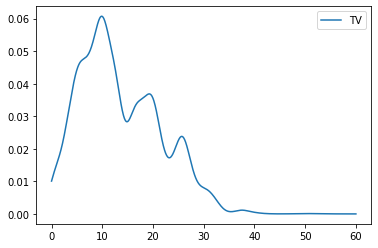

1.3603696696696697
74.95495495495496
9.90990990990991


In [6]:
for i in range(1000):
    k = kAutomata.step()
    tn = int(tnAutomata.step())
    tv = int(tvAutomata.step())

    controller = PID(k,tn,tv)

    y_simulated = response(controller,u,startPoint)
    J = np.sum(np.abs(u - y_simulated))
    kAutomata.update(J)
    tnAutomata.update(J)
    tvAutomata.update(J)
    if(i%100!=0): continue
    print(i, J)
    
array = np.array(kAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(kAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for K')
plt.show()

array = np.array(tnAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tnAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TN')
plt.show()

array = np.array(tvAutomata.historyProbabilityDistribution)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface( array[:,:,0],np.array(tvAutomata.Z),array[:,:,1], cmap='viridis',\
                edgecolor='green')
ax.set_title('History for TV')
plt.show()

array = np.array(kAutomata.probabilityDistribution)
plt.plot(array[:,0],array[:,1],label="K")
plt.legend()
plt.show()
array = np.array(tnAutomata.probabilityDistribution)
plt.plot(array[:,0],array[:,1],label="TN")
plt.legend()
plt.show()
array = np.array(tvAutomata.probabilityDistribution)
plt.plot(array[:,0],array[:,1],label="TV")
plt.legend()
plt.show()

print(kAutomata.greatestValue())
print(tnAutomata.greatestValue())
print(tvAutomata.greatestValue())


3247.053169313282


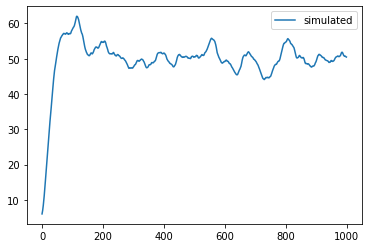

In [5]:
controller = PID(kAutomata.greatestValue(),
                int(tnAutomata.greatestValue()),
                int(tvAutomata.greatestValue()))
y_simulated = response(controller,u,startPoint)
print(np.sum(np.abs(u - y_simulated))) 
plt.plot(y_simulated,label="simulated")
plt.legend()
plt.show()